<a href="https://colab.research.google.com/github/noteisenheim/investigating_gans/blob/main/style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Style Transfer

The tutorial from the TensorFlow

Firstly, we test the pretrained style transfer on VGG-19 network, then use a gradient descent in order to create the same result

In [1]:
# import needed libraries

import os
import tensorflow as tf
# load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

from google.colab import files
from io import BytesIO

## Importing images

In [2]:
def tensor_to_image(tensor):
    # convert a tensor to the PIL image
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        tensor = tensor[0]
    
    return PIL.Image.fromarray(tensor)

In [4]:
def load_image(image):
    # converts PIL image to tensor
    # reshapes to the maximum size of 512
    max_dim = 512
    img = tf.convert_to_tensor(np.array(image))
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]

    return img

In [5]:
def show_image(img):
    if len(img.shape) > 3:
        img = tf.squeeze(img, axis=0)
    plt.imshow(img)

In [6]:
# upload a photo for style transfer
print("Upload a photo to transfer a style onto: ")
uploaded = files.upload()

for k in uploaded.keys():
    content = load_image(PIL.Image.open(BytesIO(uploaded[k])))

Upload a photo to transfer a style onto: 


Saving img.jpg to img.jpg


In [7]:
# upload a photo of a style
print("Upload a photo of a style for transferring: ")
uploaded = files.upload()

for k in uploaded.keys():
    style = load_image(PIL.Image.open(BytesIO(uploaded[k])))

Upload a photo of a style for transferring: 


Saving style.jpg to style.jpg


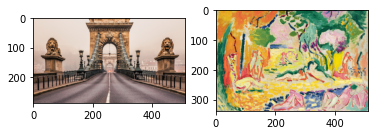

In [8]:
# displaying images
plt.subplot(121)
show_image(content)

plt.subplot(122)
show_image(style)

## Running the pretrained model

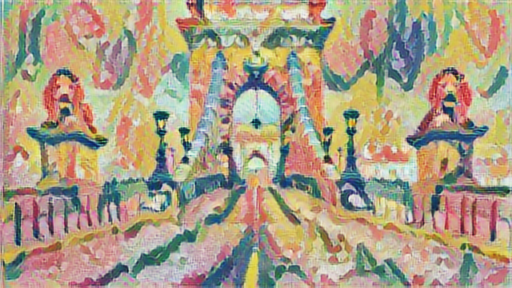

In [9]:
# using the pretrained model
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content), tf.constant(style))[0]
tensor_to_image(stylized_image)

In [10]:
# checking whether the network is working
x = tf.keras.applications.vgg19.preprocess_input(content * 255)
x = tf.image.resize(x, (224, 224))

vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')

prediction_probabilities = vgg(x)
prediction_probabilities.shape

574717952/574710816 [==============================] - 3s 0us/step


TensorShape([1, 1000])

In [11]:
# displaying the layers in the network
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
    print(layer.name)

80142336/80134624 [==============================] - 1s 0us/step

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [12]:
# using intermediary layers for style and content
content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1',
                'block4_conv1', 'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

## Extracting the outputs from the pretrained network

In [13]:
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [14]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc, bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)

    return result / num_locations

In [15]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False
    
    def call(self, inputs):
        # exract the outputs from vgg19
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                          outputs[self.num_style_layers:])
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
        content_dict = {content_name: value for content_name, value 
                        in zip(self.content_layers, content_outputs)}
        style_dict = {style_name: value for style_name, value 
                        in zip(self.style_layers, style_outputs)}
        
        return {'content': content_dict, 'style': style_dict}

In [16]:
extractor = StyleContentModel(style_layers, content_layers)
results = extractor(tf.constant(content))

print('styles:')
for name, output in sorted(results['style'].items()):
    print(name)
    print('shape: ', output.numpy().shape)
    print("min: ", output.numpy().min())
    print("max: ", output.numpy().max())
    print("mean: ", output.numpy().mean())
    print()

print('---------------------')

print('contents:')
for name, output in sorted(results['content'].items()):
    print(name)
    print('shape: ', output.numpy().shape)
    print("min: ", output.numpy().min())
    print("max: ", output.numpy().max())
    print("mean: ", output.numpy().mean())
    print()

styles:
block1_conv1
shape:  (1, 64, 64)
min:  0.018153027
max:  42521.617
mean:  527.3229

block2_conv1
shape:  (1, 128, 128)
min:  0.0
max:  172906.56
mean:  20625.637

block3_conv1
shape:  (1, 256, 256)
min:  0.0
max:  461154.1
mean:  19952.973

block4_conv1
shape:  (1, 512, 512)
min:  0.0
max:  5154875.0
mean:  321577.06

block5_conv1
shape:  (1, 512, 512)
min:  0.0
max:  209607.19
mean:  3548.264

---------------------
contents:
block5_conv2
shape:  (1, 18, 32, 512)
min:  0.0
max:  1657.705
mean:  21.666142



## Train the gradient descent

In order to obtain an image with the style transferred, we use outputs from the pretrained vgg19

In [28]:
style_targets = extractor(style)['style']
content_targets = extractor(content)['content']

In [29]:
image = tf.Variable(content)

In [30]:
def clip_0_1(image):
    return tf.clip_by_value(image, 0.0, 1.0)

In [31]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [32]:
style_weight = 1e-2
content_weight = 1e4

In [33]:
def style_content_loss(outputs):
    # loss = style loss + content loss
    # the loss used is MSE
    style_outputs = outputs['style']
    content_outputs = outputs['content']

    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name]) ** 2)
                            for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name]) ** 2)
                            for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers

    return style_loss + content_loss

In [34]:
@tf.function()
def train_step(image):
    # a single step of GD
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

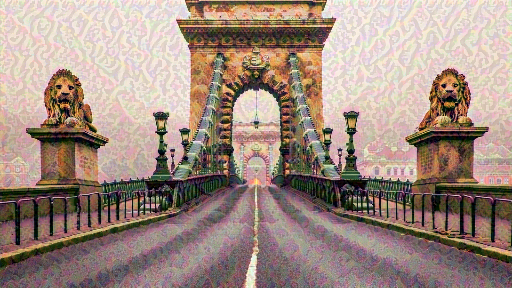

In [35]:
# perfrom several train steps in order to see whether it works
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

In [36]:
def generate_and_save_image(img, epoch):
    # helping function for saving images
    img = tensor_to_image(img)
    fig = plt.figure(figsize=(4, 4))

    plt.imshow(img)
    
    plt.savefig(f'epoch_{epoch}_img.png')
    plt.show()

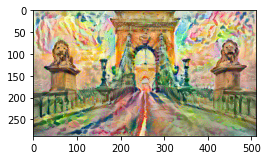

train step:  1000
total time:  61.65827822685242


In [37]:
# actual training
import time
start = time.time()

epochs = 20
steps_per_epoch = 50

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print('.', end='')
    display.clear_output(wait=True)
    generate_and_save_image(image, n)
    print('train step: ', step)

end = time.time()
print('total time: ', end - start)

## Results

In [38]:
# generate the gif from the image evolution
import imageio
import glob

anim_file = 'style_transfer.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('epoch*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [39]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-7htir0km
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-7htir0km
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.05e130adad3771f9026e78e8b0556fe39dd79a164_-cp36-none-any.whl size=145893 sha256=0ca556ad84c9f69e02c8acff0c595e82a60bd67580f236d459145e126079a5f3
  Stored in directory: /tmp/pip-ephem-wheel-cache-_kk4fpog/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs



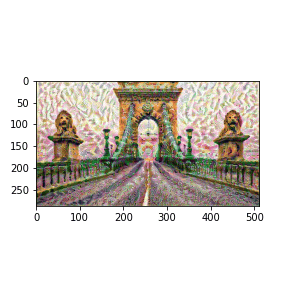

In [40]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)